In [117]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Suppress annoying warnings from pandas
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

# Data Cleaning

Here we map the names of the animal classes in ```class.csv``` to their corresponding ids in ```zoo.csv```.

In [149]:
animals = pd.read_csv('../data/zoo.csv')
animals.drop(['animal_name'], axis=1, inplace=True) # Not a predictor

In [150]:
classes = pd.read_csv('../data/class.csv')
classes.columns = [col.lower() for col in classes.columns]
classes = classes[['class_number', 'class_type']].rename({'class_type':'class_name', 'class_number':'class_type'}, axis=1)

In [ ]:
animals = animals.merge(classes)

# Class Counts
Amphibians and reptiles have very few observations, and they are objectively pretty similar animals. I imagine that they will be tough to tell apart. Bugs and invertebrates are probably in a similar situation.

In [ ]:
import seaborn as sns
import matplotlib.cm as cm
from matplotlib.colors import rgb2hex

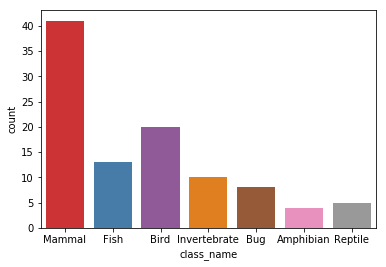

In [219]:
cmap = cm.get_cmap('Set1', 7)
colors = [rgb2hex(cmap(i)[:3]) for i in range(7)]
sns.countplot(x='class_name', data=animals, palette=colors)

# Correlation Matrix

Milk has strong correlations with both hair and eggs. This might be an indidcation that we can drop one of the variables.

Text(0.5,1,'Correlation Matrix of Animal Class Predictors')

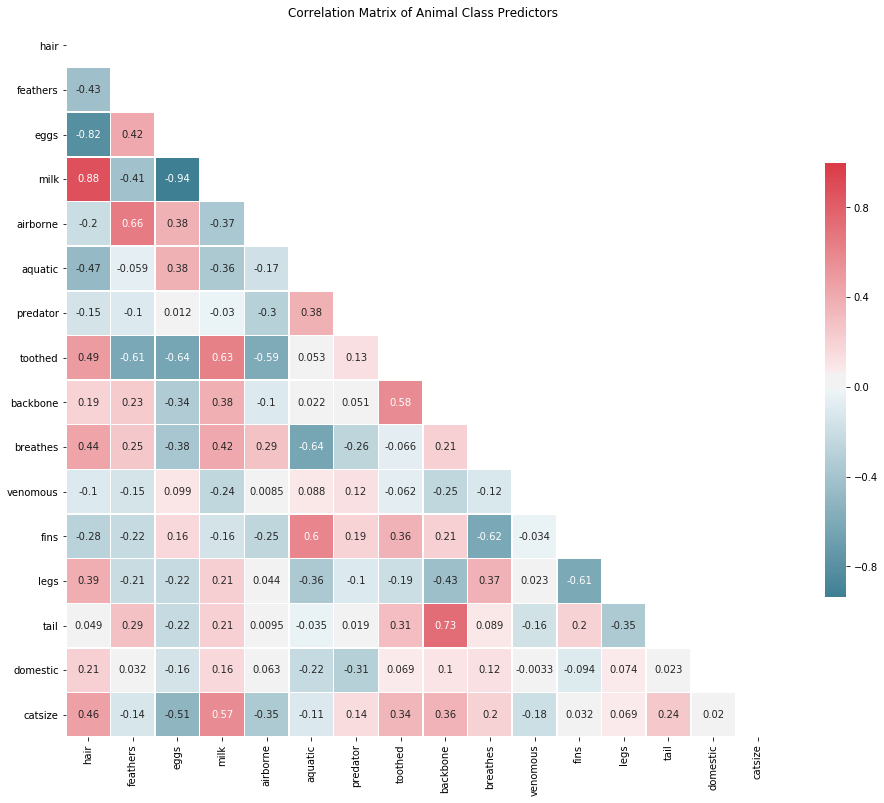

In [215]:
# Compute the correlation matrix
corr = animals[features].corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(16, 16))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, annot=True, square=True, linewidths=.5, cbar_kws={"shrink": .5})
ax.set_title('Correlation Matrix of Animal Class Predictors')

# Dimension Reduction

I'll start by trying some of the typical approaches for dimensionality reduction to see if we can tease out some separation amongst the classes.

In [178]:
from sklearn.decomposition import FactorAnalysis, PCA, NMF, TruncatedSVD as LSA
from sklearn.cross_decomposition import CCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

In [186]:
def plot_decomp(X, y, targets, subplot, transform, dims):
    
    if transform == "PCA":
        X_r = PCA(n_components=dims).fit_transform(X)
    elif transform == "NMF":
        X_r = NMF(n_components=dims).fit_transform(X)
    elif transform == "LDA":
        X_r = LDA(n_components=dims).fit(X, y).transform(X)
    elif transform == "FA":
        X_r = FactorAnalysis(n_components=dims).fit(X, y).transform(X)
    elif transform == "LSA":
        X_r = LSA(n_components=dims).fit(X, y).transform(X)
    elif transform == "CCA":
        X_r = CCA(n_components=dims).fit(X, y).transform(X)
    else:
        raise ValueError
    
    n_classes = len(targets)
    
    cmap = cm.get_cmap('Set1', n_classes)
    colors = [rgb2hex(cmap(i)[:3]) for i in range(n_classes)]
        
    if dims == 2:
        lw = 2
        plt.subplot(2, 2, subplot)

        for color, i, target in zip(colors, np.arange(1, n_classes+1), targets):
            plt.scatter(X_r[y == i, 0], X_r[y == i, 1], color=color, alpha=.8, lw=lw, label=target)

    elif dims == 3:
        lw = 3
        plt.subplot(2, 2, subplot, projection='3d')

        for color, i, target in zip(colors, np.arange(1, n_classes+1), targets):
            plt.scatter(X_r[y == i, 0], X_r[y == i, 1], X_r[y==i, 2], color=color, alpha=.8, lw=lw, label=target)

    else:
        raise ValueError

    if subplot == 1:
        plt.legend(loc='best', shadow=False, scatterpoints=1)

    plt.title(transform + ' of Animals dataset')

In [220]:
def plot_decomp_grid(X, y, targets, transforms=['PCA', 'LDA', 'CCA', 'FA'], dims=2):
    plt.figure(figsize=(16, 12))
    for i,tf in enumerate(transforms):
        plot_decomp(X, y, targets, i+1, tf, dims)

    plt.show()

## 2D Plots

### PCA, LDA, CCA, and LSA

In [221]:
targets = animals.class_name.unique()
features = animals.drop(['class_type', 'class_name'], axis=1).columns

X = animals[features].as_matrix()
y = animals.class_type.as_matrix()

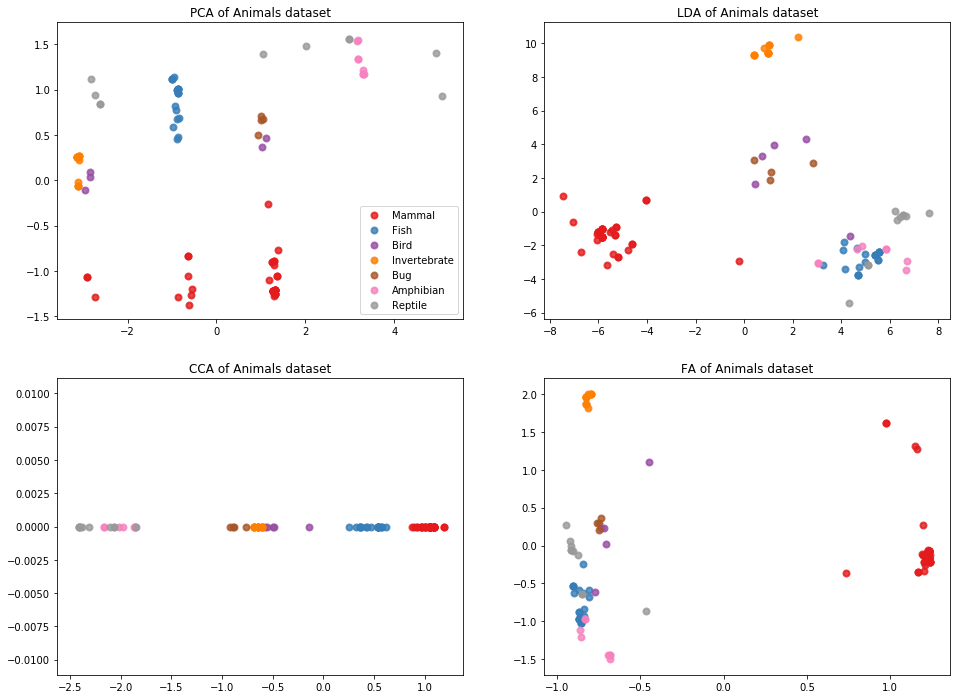

In [222]:
plot_decomp_grid(X, y, targets)

### PCA, LDA, CCA, and LSA w/o Animals and Fish

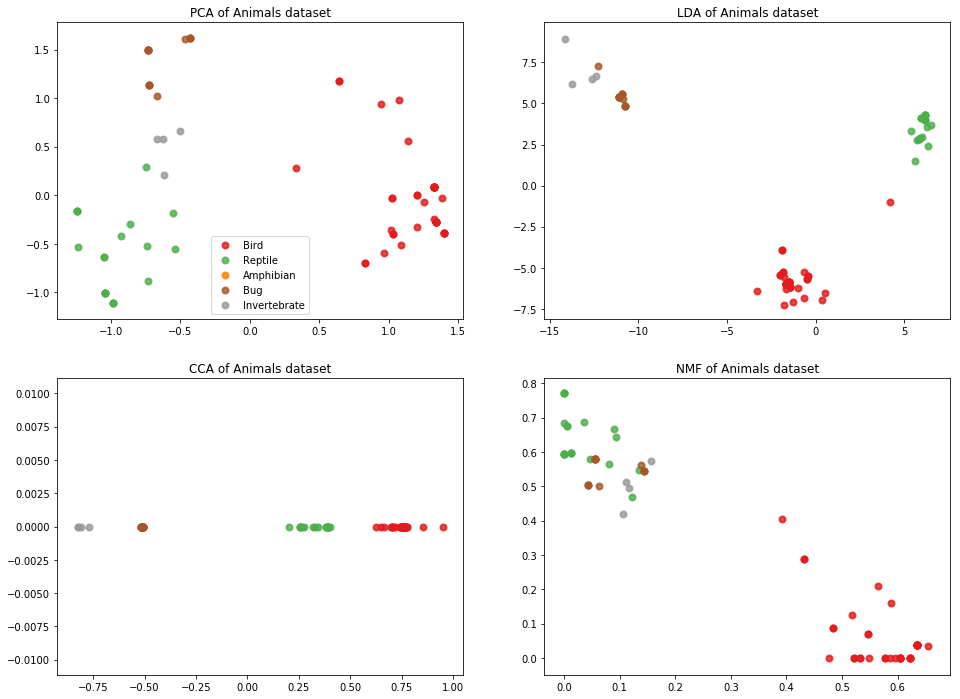

In [184]:
targets = ['Bird', 'Reptile', 'Amphibian', 'Bug', 'Invertebrate']
X = animals[~animals.class_type.isin([0, 3])][features].as_matrix()
y = animals[~animals.class_type.isin([0, 3])].class_type.as_matrix()

plot_decomp_grid(X, y, targets)

## 3D LDA Plot

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

In [161]:
targets = ['Mammal', 'Bird', 'Reptile', 'Fish', 'Amphibian', 'Bug', 'Invertebrate']
n_classes = len(targets)
features = animals.drop(['class_type', 'class_name'], axis=1).columns

X = animals[features].as_matrix()
y = animals.class_type.as_matrix()

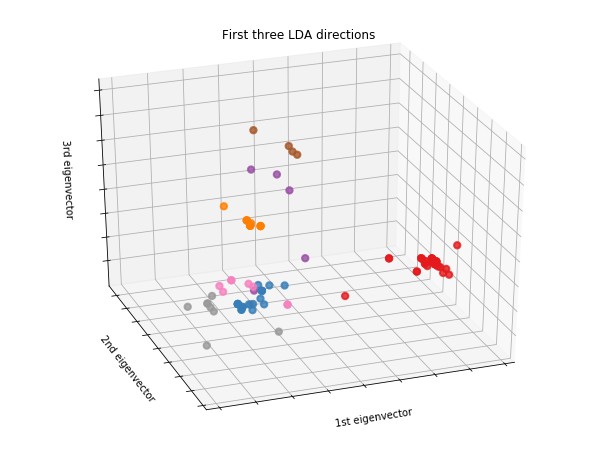

In [162]:
X_r = LDA(n_components=3).fit(X, y).transform(X)

cmap = cm.get_cmap('Set1', n_classes)
colors = [rgb2hex(cmap(i)[:3]) for i in range(n_classes)]

fig = plt.figure(figsize=(8, 6))
ax = Axes3D(fig, elev=-150, azim=110)
for color, i, target in zip(colors, np.arange(1, n_classes+1), targets):
    ax.scatter(X_r[y == i, 0], X_r[y == i, 1], X_r[y==i, 2], color=color, alpha=.8, lw=2, label=target, s=40)

ax.set_title("First three LDA directions")
ax.set_xlabel("1st eigenvector")
ax.w_xaxis.set_ticklabels([])
ax.set_ylabel("2nd eigenvector")
ax.w_yaxis.set_ticklabels([])
ax.set_zlabel("3rd eigenvector")
ax.w_zaxis.set_ticklabels([])

plt.show()


# Manifold Learning
Manifold learning is an approach to non-linear dimensionality reduction. Algorithms for this task are based on the idea that the dimensionality of many data sets is only artificially high.

## t-SNE (t-distributed Stochastic Neighbor Embedding)
t-SNE is a tool to visualize high-dimensional data. It converts similarities between data points to joint probabilities and tries to minimize the Kullback-Leibler divergence between the joint probabilities of the low-dimensional embedding and the high-dimensional data. t-SNE has a cost function that is not convex, i.e. with different initializations we can get different results. [Inspiration](http://scikit-learn.org/stable/auto_examples/manifold/plot_lle_digits.html#sphx-glr-auto-examples-manifold-plot-lle-digits-py)

# TALK TO DR RACE ABOUT SCALING

In [259]:
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split

In [226]:
targets = ['Mammal', 'Bird', 'Reptile', 'Fish', 'Amphibian', 'Bug', 'Invertebrate']
n_classes = len(targets)
features = animals.drop(['class_type', 'class_name'], axis=1).columns

X = animals[features].as_matrix()
y = animals.class_type.as_matrix()

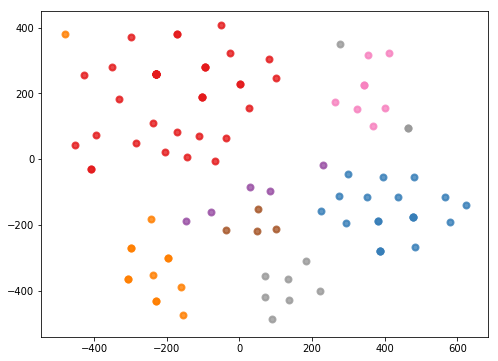

In [239]:
tsne = TSNE(n_components=2, init='pca', random_state=0)
X_r = tsne.fit_transform(X)

lw = 2
plt.figure(figsize=(8,6))

for color, i, target in zip(colors, np.arange(1, n_classes+1), targets):
    plt.scatter(X_r[y == i, 0], X_r[y == i, 1], color=color, alpha=.8, lw=lw, label=target)

I'm curious to see if things change when using LDA as for our init parameter.

In [ ]:
init = LDA(n_components=2).fit(X, y).transform(X)
tsne = TSNE(n_components=2, init=init, random_state=0)
X_r = tsne.fit_transform(X)

lw = 2
plt.figure(figsize=(8,6))

for color, i, target in zip(colors, np.arange(1, n_classes+1), targets):
    plt.scatter(X_r[y == i, 0], X_r[y == i, 1], color=color, alpha=.8, lw=lw, label=target)

It might be a little bit better...pretty hard to tell though. Now the real question...can this be done with canonical correlation analysis? I'm doubtful to say the least.

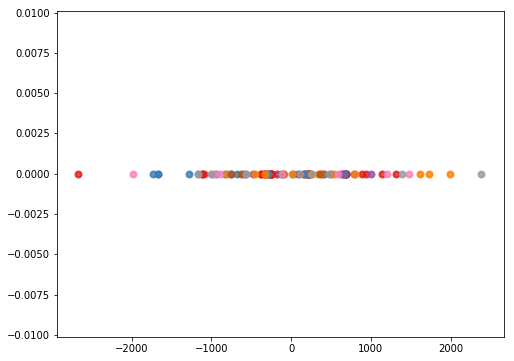

In [235]:
init = CCA(n_components=2).fit(X, y).transform(X)
tsne = TSNE(n_components=2, init=init, random_state=0)
X_r = tsne.fit_transform(X)

lw = 2
plt.figure(figsize=(8,6))

for color, i, target in zip(colors, np.arange(1, n_classes+1), targets):
    plt.scatter(X_r[y == i, 0], X_r[y == i, 1], color=color, alpha=.8, lw=lw, label=target)

lol ya that's not gonna cut it

# K Neighbors Classifier

In [298]:
from sklearn.pipeline import make_pipeline, make_union
from sklearn.neighbors import KNeighborsClassifier
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import cross_val_score
from sklearn.feature_selection import mutual_info_classif

In [250]:
svc.predict(X_r)

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 6, 6, 6, 6, 6, 6, 6, 6,
       5, 5, 5, 5, 3, 3, 3, 3, 3], dtype=int64)

In [268]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

In [276]:
params = {'n_neighbors': np.arange(20) + 5}
gscv = GridSearchCV(KNeighborsClassifier(), params, cv=10)

In [277]:
gscv.fit(X, y)

C:\Users\samba\Anaconda3\lib\site-packages\sklearn\cross_validation.py:553: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=10.
  % (min_labels, self.n_folds)), Warning)


GridSearchCV(cv=10, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_neighbors': array([ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21,
       22, 23, 24])},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [312]:
k_scores = []
k_range = np.arange(1, 20)

for k in k_range:
    knn = make_pipeline(PCA(n_components=2), KNeighborsClassifier(n_neighbors=k))
    scores = cross_val_score(knn, X_train, y_train, cv=3, scoring='neg_log_loss')
    k_scores.append(scores.mean())

In [320]:
from sklearn.metrics import accuracy_score
knn = KNeighborsClassifier(1)

In [321]:
knn.fit(X_train, y_train)
accuracy_score(y_test, knn.predict(X_test))

1.0

In [303]:
from sklearn.cluster import KMeans

In [304]:
km = KMeans(7)

In [306]:
output = km.fit_transform(X)

In [310]:
km.labels_

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 2, 6, 2, 6, 2, 6, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 4, 2, 2, 2, 2, 4, 6, 6, 6, 2, 6, 2, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 0, 1, 5, 5, 5, 5, 0, 0, 1, 0, 5, 5, 5, 5, 5, 5, 5, 5,
       1, 1, 1, 1, 0, 4, 0, 1, 1])